# BGG Boardgame Recommendation Engine
## Part 2: Preprocessing and Modelling
<img src='nb-assets/dice2.jpg'>

Now that the data has been collected, let's start on the next steps towards building the recommendation engine. The data first needs to be consolidated and cleaned. Then, features need to be engineered in such a way that we can use machine learning to draw some insight from them. Then a model needs to be fit (in this case, nearest neighbor). Finally, we need to evaluate the recommendations returned by this model. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
sns.set()

## Loading and cleaning the data

A few things have to be dealt with here:
- The multiple dataframes will need to be joined
- Missing data needs to be identified and filled
- Datatypes need to be converted to the most appropriate dtype for the column

In [13]:
# Merge the data into a single notebook
df_1 = pd.read_csv('data/details_final.csv', names=['id', 'players', 'solo', 'age', 'playtime', 'description', 'designers', 'publisher', 'awards', 'categories', 'mechanics'])
df_2 = pd.read_csv('data/final_extra_details.csv')
df_3 = pd.read_csv('data/ranks.csv')
df = pd.merge(df_3, df_2, on='id')
df = pd.merge(df, df_1, on='id')

In [43]:
# Address nulls in the "best_players" column
# Of the non-nulls, there is about a 60:40 split between cases
# where best = max and best = min players, respectively. So I'll
# fill these nulls with the mean (rounded up, because max > min) 
# of the minimum and maximum player count

fill_vals = np.ceil(df.loc[df.best_players.isna()].min_players + df.loc[df.best_players.isna()].players / 2)

df.best_players = df.best_players.fillna(fill_vals)

In [47]:
# Address data types of numeric columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19996 entries, 0 to 19995
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19996 non-null  int64  
 1   title         19996 non-null  object 
 2   year          19996 non-null  object 
 3   url           19996 non-null  object 
 4   user_score    19996 non-null  float64
 5   votes         19996 non-null  int64  
 6   best_players  19996 non-null  float64
 7   min_players   19996 non-null  int64  
 8   max_playtime  19996 non-null  int64  
 9   weight        19996 non-null  float64
 10  players       19996 non-null  int64  
 11  solo          19996 non-null  object 
 12  age           19996 non-null  int64  
 13  playtime      19996 non-null  int64  
 14  description   19996 non-null  object 
 15  designers     19996 non-null  object 
 16  publisher     19996 non-null  object 
 17  awards        19996 non-null  int64  
 18  categories    19996 non-nu

In [ ]:
# 'year' to numeric
df.year = pd.to_numeric(df.year, errors='coerce')

In [52]:
# There are some missing year values in the data
# - replace with the average of the top 10 years
average_year = np.floor(df.year.value_counts().iloc[:10].index.values.mean())
df.year = df.year.fillna(average_year)
df.year = df.year.astype('int')

In [79]:
# I can safely use eval - I collected the data myself!
df.solo = df.solo.apply(eval)

In [116]:
# Save the current data as a kind of checkpoint 
# df.to_csv('data/data_clean.csv', index=False)

## Feature engineering

Goals in this section:
- Convert the lengthy prose description of each game into a meaningful feature
- Change the form of the 'year' column to something more useful
- Perform one-hot-encoding and multilabel binarizing as needed

In [83]:
# Get the descriptions
descriptions = df.description

In [125]:
# Use TF-IDF (unigram, digram) as a basis for clustering 
# descriptions. This will take the prose description and 
# extract themes based on recurrent keywords and from that
# we can create labels, adding dimensionality 
tv = TfidfVectorizer(ngram_range=(1, 2), max_df=.9, min_df=.01)
word_vectors = tv.fit_transform(descriptions.values)
word_vectors = np.asarray(word_vectors.todense())

In [508]:
# N clusters of 20 - this is fairly arbitrary.
# The goal is just to create a decent variety 
# of clusters to hopefully pick out some novel 
# similarities among the description fields
kmeans = MiniBatchKMeans(n_clusters=20, random_state=1337)
labels = kmeans.fit_predict(word_vectors)

df['labels'] = labels

In [232]:
# Instead of using the years column, split games by age.
# Any game less than 20 years old will be considered 'modern'
df['modern'] = df.year.apply(lambda x: 0 if x < 2002 else 1)

In [510]:
# OHE the publisher and label columns
publisher = pd.get_dummies(df.publisher, drop_first=True)
labels = pd.get_dummies(df.labels, drop_first=True)
# Use MultiLabelBinarizer to binarize the remaining columns
mlb = MultiLabelBinarizer()
designers = mlb.fit_transform(df.designers)
categories = mlb.fit_transform(df.categories)
mechanics = mlb.fit_transform(df.mechanics)
binaries = np.concatenate((labels, designers, publisher, categories, mechanics), axis=1)

In [511]:
# Collect the remaining features and combine with the OHE/MLB features
X = df.filter(['best_players', 'min_players', 'max_playtime', 'playtime', 'weight', 'user_score', 'solo', 'age', 'awards', 'modern'])
X = np.concatenate((binaries, X.to_numpy()), axis=1)
# Scale the collected features
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Modelling

The approach taken is a straightforward one: [nearest neighbours](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) search to identify similar games.

For a single reference game, it will be as simple as calculating distance (ultimately using [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry)) and returning the closest points. 

With a list of reference games, I'll write a function to calculate the average point of the list, and we'll find nearest neighbours from that single point - this way, recommendations will be based on a combination of elements of the whole list.

In [512]:
# To mitigate the "curse of dimensionality" in the KNN
# search, use Minkowski distance (a generalization of both
# Euclidean and Manhattan distances) as the metric
# to measure distance. Trialing different values
# of p (1 <= p <=2) found the best results at p=1.
knn = NearestNeighbors(metric='minkowski', p=1)
knn.fit(X)

NearestNeighbors(p=1)

In [128]:
# Define a function for averaging the list of games

def centroid(games: list[int]) -> np.ndarray:
    """
    Calculate the centre of a list of points.
    
    Parameters:
    -----------
    games: list 
        List of indices of games the user likes
        
    Returns:
    --------
    np.ndarray 
        Vector containing the average of each dimension
    """
    
    if len(games) == 1:
        return X[games[0]]
    points = [X[game] for game in games]
    centroid = np.sum(points, axis=0) / len(points)
    return centroid

## Testing

Evaluating a model like this is a challenge in itself. The quality of recommendations is a matter of taste, and can't be measured quantitatively. As an heuristic, I've elected to take samples of games that are known to be similar and compare the recommendations we receive based on them. Then, we can see what recommendations we get from a random sampling of games. 

In [604]:
# Test with a few games from the "Pandemic" franchise
lst = df.loc[df.title.str.startswith("Pandemic")][:5].id.index.values
test = centroid(lst)

In [605]:
recommendations = knn.kneighbors(test.reshape(1,-1), 25, return_distance=False)[0]

In [606]:
for rec in recommendations:
    print(df.iloc[rec].title.ljust(60), df.iloc[rec].designers, df.iloc[rec].publisher)

Pandemic Legacy: Season 1                                    ['Rob Daviau', 'Matt Leacock'] Z-Man Games
Pandemic Legacy: Season 2                                    ['Rob Daviau', 'Matt Leacock'] Z-Man Games
Pandemic Legacy: Season 0                                    ['Rob Daviau', 'Matt Leacock'] Z-Man Games
Pandemic                                                     ['Matt Leacock'] Z-Man Games
Pandemic: Rising Tide                                        ['Jeroen Doumen', 'Matt Leacock'] Z-Man Games
Pandemic: The Cure                                           ['Matt Leacock'] Z-Man Games
Pandemic: Fall of Rome                                       ['Matt Leacock', 'Paolo Mori'] Z-Man Games
Pandemic: Hot Zone – North America                           ['Matt Leacock'] Z-Man Games
Pandemic: Hot Zone – Europe                                  ['Matt Leacock', 'Thomas Lehmann'] Z-Man Games
Pandemic: Iberia                                             ['Jesús Torres Castro', 'Matt Leacock'

---
When given 5 _Pandemic_ games as an input, the top recommendations includes 12/13 of the _Pandemic_ games in the dataset, along with other games by the same publisher (_Z-Man Games_), or the designers (Rob Daviau and Matt Leacock).

---

In [607]:
# Let's test with another keyword: "Monopoly"
lst = df.loc[df.title.str.startswith("Monopoly")][:5].id.index.values
test = centroid(lst)

In [608]:
recommendations = knn.kneighbors(test.reshape(1, -1), 25, return_distance=False)[0]

In [609]:
for rec in recommendations:
    print(df.iloc[rec].title.ljust(50), df.iloc[rec].categories, df.iloc[rec].min_players)

Monopoly Millionaire Deal Card Game                ['Card Game', 'Economic'] 2
Monopoly Gamer                                     ['Economic', 'Video Game Theme'] 2
Monopoly Gamer: Mario Kart                         ['Economic', 'Video Game Theme'] 2
Monopoly Deal Card Game                            ['Card Game', 'Economic'] 2
Monopoly Bid                                       ['Card Game', 'Economic'] 2
Monopoly Gamer: Sonic The Hedgehog                 ['Animals', 'Economic', 'Video Game Theme'] 2
Monopoly Deal                                      ['Card Game'] 2
Goatfish                                           ['Animals', 'Card Game'] 2
Zen Master                                         ['Card Game'] 3
Llamas Unleashed                                   ['Animals', 'Card Game', 'Humor'] 2
Butts in Space: The Card Game                      ['Card Game'] 2
Yaniv                                              ['Card Game'] 2
Hasty Baker                                        ['Card Gam

---
Given a list of _Monopoly_ games (3 of which have a card game theme), we get recommendations for more _Monopoly_ games, card games, and games where you can play with 2 players.

---

In [570]:
# Finally, testing with a random sample of games
lst = df.sample(5).id.index.values
test = centroid(lst)

In [572]:
recommendations = knn.kneighbors(test.reshape(1, -1), 25, return_distance=False)[0]

In [600]:
print('Random list of games:')
for id_ in lst:
    print(df.iloc[id_].title.ljust(60), df.iloc[id_].categories)
print('\nRecommendations:')
for rec in recommendations:
    print(df.iloc[rec].title.ljust(60), df.iloc[rec].categories)

Random list of games:
Balance Elemental                                            ['Memory']
Krieg! World War II in Europe                                ['Wargame', 'World War II']
Halloween                                                    ['Horror', 'Miniatures']
Hannut: France 1940                                          ['Wargame', 'World War II']
Skat                                                         ['Card Game']

Recommendations:
Over the Top! Lemberg 1914 & Verdun 1916                     ['Wargame', 'World War I']
World War I: Deluxe Edition                                  ['Wargame', 'World War I']
Balkans 1941                                                 ['Wargame', 'World War II']
Hannut: France 1940                                          ['Wargame', 'World War II']
Krieg! World War II in Europe                                ['Wargame', 'World War II']
The Old Contemptibles at Mons, 1914                          ['Wargame', 'World War I']
Over the Top! Mons

---
And here's a natural limitation of using KNN (and a problem with recommendation engines generally): The random sample of games selected happened to have two games from the "Wargame" and "World War II" categories, leading to a ton of games about war, mainly WWII. It's not clear at all what effect, if any, the 3 other games had on these recommendations.

---

## Addendum: Version 2

I thought this model was decent. Looked like it was producing relevant recommendations based on the data fed into it. However, after building a webpage around it and deploying it, there were three serious issues that need to be addressed:
- Size. The feature matrix of 19997 x 4166 has to be loaded into memory for the knn model to generate recommendations. The fit model weighs in at 666mb.. its size was a major issue in deployment. It's too large for a Heroku web app, so I had to deploy to Azure. This led to the next problem:
- Computational complexity. Nearest neighbours is not cheap! For N-samples in D-dimensions, scikit-learn's KNN search complexity ranges from O(DlogN) to O(DN) (depending on data and algorithm). But there was one more problem..
- The top 20,000 rated games weren't enough. After running a few tests on family members, I noticed that while the dataset included my favourite board games, it didn't actually include some of the most popular games among people who aren't, well, board game geeks. 

So I need more data. And the data to take up less space. OK.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
sns.set()

In [2]:
# Scraped another 5000 records
df = pd.read_csv('data/data_v2.csv')

In [149]:
# This time I'll take a different approach to playtime
# and segment games into short, medium, and long 

df['avgplay'] = (df.playtime + df.max_playtime) / 2

In [150]:
df.avgplay = df.avgplay.apply(lambda x: 'short' if x < 45 else ('medium' if x < 90 else 'long'))

In [151]:
df = df.drop(columns=['max_playtime', 'playtime'])

In [152]:
# Tweak the max_df down to .5
descriptions = df.description
tv = TfidfVectorizer(ngram_range=(1, 2), max_df=.5, min_df=.01)
word_vectors = tv.fit_transform(descriptions.values)
word_vectors = np.asarray(word_vectors.todense())

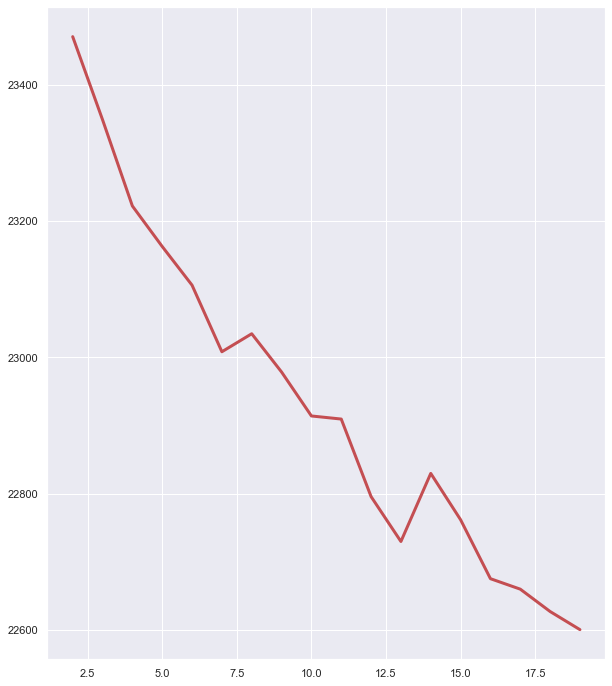

In [153]:
# Try a smaller cluster count informed by an elbow plot
wcss = []
range_ = range(2, 20)

for i in range_:
    kmeans = MiniBatchKMeans(i, random_state=1337)
    kmeans.fit(word_vectors)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_

fig, ax = plt.subplots(figsize=(10, 12))
ax.plot(range_, wcss, c='r', lw=3)

In [154]:
kmeans = MiniBatchKMeans(n_clusters=13, random_state=1337)
labels = kmeans.fit_predict(word_vectors)
df['labels'] = labels

In [155]:
# The "votes" category records how many reviews a game has received
# As a proxy for popularity, I'll remove all games that don't meet
# a threshold number of votes
thresh = 100
df = df.loc[df.votes >= thresh]
df = df.reset_index(drop=True)

In [156]:
df['modern'] = df.year.apply(lambda x: 0 if x < 2002 else 1)

In [174]:
# Same process as before:
# OHE the publisher and label columns
avgplay = pd.get_dummies(df.avgplay, drop_first=True)
publisher = pd.get_dummies(df.publisher, drop_first=True)
labels = pd.get_dummies(df.labels, drop_first=True)
# Use MultiLabelBinarizer to binarize the remaining columns
mlb = MultiLabelBinarizer()
designers = mlb.fit_transform(df.designers)
categories = mlb.fit_transform(df.categories)
mechanics = mlb.fit_transform(df.mechanics)
binaries = np.concatenate((avgplay, labels, designers, publisher, categories, mechanics), axis=1)
# Collect the remaining features and combine with the OHE/MLB features
X = df.filter(['best_players', 'players', 'weight', 'user_score', 'solo', 'age', 'awards', 'modern'])
X = np.concatenate((binaries, X.to_numpy()), axis=1)
# Scale the collected features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [175]:
pca = PCA(n_components=250)

In [176]:
pca.fit(X)

PCA(n_components=250)

In [177]:
pca.explained_variance_ratio_.sum() # 250 - 18 500 - 28 - 100 - 11

0.18297460519067005

---
I tested a few different levels reduction with PCA. At 500 components (28% explained variance), results were pretty much the same as the prior model. As low as 100 components (11% explained variance), results appear to be much less similar with each other. In the interest of reducing final deployment size, I'm settling at 250 components with 18% explained variance. Results below.

---

In [178]:
X = pca.transform(X)

In [179]:
knn = NearestNeighbors(metric='minkowski', p=1)
knn.fit(X)
lst = df.loc[df.title.str.startswith("Pandemic")][:5].id.index.values
test = centroid(lst)
recommendations = knn.kneighbors(test.reshape(1,-1), 25, return_distance=False)[0]
for rec in recommendations:
    print(df.iloc[rec].title.ljust(60), df.iloc[rec].designers, df.iloc[rec].publisher)

Pandemic Legacy: Season 2                                    ['Rob Daviau', 'Matt Leacock'] Z-Man Games
Pandemic Legacy: Season 1                                    ['Rob Daviau', 'Matt Leacock'] Z-Man Games
Pandemic Legacy: Season 0                                    ['Rob Daviau', 'Matt Leacock'] Z-Man Games
Pandemic: Rising Tide                                        ['Jeroen Doumen', 'Matt Leacock'] Z-Man Games
Pandemic                                                     ['Matt Leacock'] Z-Man Games
Pandemic: Fall of Rome                                       ['Matt Leacock', 'Paolo Mori'] Z-Man Games
Pandemic: The Cure                                           ['Matt Leacock'] Z-Man Games
Pandemic: Hot Zone – Europe                                  ['Matt Leacock', 'Thomas Lehmann'] Z-Man Games
Pandemic: Hot Zone – North America                           ['Matt Leacock'] Z-Man Games
Battle Beyond Space                                          ['Frank Branham'] Z-Man Games
Undermin

In [180]:
# Let's test with another keyword: "Monopoly"
lst = df.loc[df.title.str.startswith("Monopoly")][:5].id.index.values
test = centroid(lst)
recommendations = knn.kneighbors(test.reshape(1, -1), 25, return_distance=False)[0]
for rec in recommendations:
    print(df.iloc[rec].title.ljust(50), df.iloc[rec].categories, df.iloc[rec].min_players)

Monopoly Millionaire Deal Card Game                ['Card Game', 'Economic'] 2
Free Parking                                       ['Card Game', 'Transportation'] 2
Monopoly Deal Card Game                            ['Card Game', 'Economic'] 2
Monopoly Gamer: Mario Kart                         ['Economic', 'Video Game Theme'] 2
Monopoly Gamer                                     ['Economic', 'Video Game Theme'] 2
Monopoly: Stock Exchange                           ['Economic', 'Electronic', 'Negotiation'] 2
eBay Electronic Talking Auction Game               ['Card Game', 'Electronic'] 3
The Game of Life: Twists & Turns                   ['Economic', 'Electronic'] 2
Megastar                                           ['Card Game', 'Music'] 2
Monopoly Bid                                       ['Card Game', 'Economic'] 2
I'm the Boss!: The Card Game                       ['Card Game', 'Economic', 'Negotiation'] 3
Head-to-Head Poker                                 ['Bluffing', 'Card Game'] 2
M

In [182]:
# Finally, testing with a random sample of games
lst = df.sample(5).id.index.values
test = centroid(lst)
recommendations = knn.kneighbors(test.reshape(1, -1), 25, return_distance=False)[0]
print('Random list of games:')
for id_ in lst:
    print(df.iloc[id_].title.ljust(60), df.iloc[id_].categories)
print('\nRecommendations:')
for rec in recommendations:
    print(df.iloc[rec].title.ljust(60), df.iloc[rec].categories)

Random list of games:
The Night Cage                                               ['Horror', 'Maze']
DiceWar: Light of Dragons                                    ['Dice', 'Fantasy']
Start Player: A Kinda Collectible Card Game                  ['Card Game', 'Collectible Components', 'Comic Book / Strip', 'Humor']
Tsuro of the Seas                                            ['Abstract Strategy', 'Nautical']
Bee Alert                                                    ['Animals', "Children's Game", 'Memory']

Recommendations:
Reverse Charades                                             ['Party Game']
25 Words or Less                                             ['Party Game', 'Word Game']
Mall World                                                   ['Economic', 'Territory Building']
The 3 Commandments                                           ['Deduction', 'Fantasy', 'Memory', 'Party Game']
Ad Acta                                                      ['Card Game']
Wits & Wagers: It's Vega

Interesting random results. The theme is party games for sure. I bet it would be interesting to play some games from both the random list and the recommendations and see how similar they are. If I had time for that!

In [185]:
df.to_csv('data/data_compact.csv')

In [186]:
np.savez_compressed('data/x_compact.npz', X=X)